# Mathematical Underpinnings - Lab 7

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [2]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    return 1/2 * ((np.transpose(mu2 - mu1) @ np.linalg.inv(Sigma2) @ (mu2 - mu1))[0][0] + np.matrix.trace(np.linalg.inv(Sigma2) * Sigma1) - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma1)) - len(mu1))


In [3]:
# compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
def T_opt(x, mu1, mu2, Sigma1, Sigma2):

    def normal_for_x(x, mu, sigma):
        value = (2*np.pi)**(-len(x)/2)*np.linalg.det(sigma)**(-1/2)*np.exp((-1/2 * np.transpose(x - mu) @ np.linalg.inv(sigma) @ (x - mu))[0][0])
        return value

    res = []
    for i in range(x.shape[0]):
        x_t = np.reshape(x[i, :], (-1,1))
        res.append(np.log(normal_for_x(x_t, mu1, Sigma1)/normal_for_x(x_t, mu2, Sigma2)))

    return np.asarray(res)

### b)

In [4]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

np.random.seed(123)

mu1 = np.asarray([0.2, 0.2, 0.2, 0, 0]).T
mu2 = np.asarray([0, 0, 0.2, 0.2, 0.2]).T
n = 10000
ro1 = 0.1
ro2 = -0.2

Sigma1 = np.full((5, 5), ro1)
Sigma2 = np.full((5, 5), ro2)
np.fill_diagonal(Sigma1, 1)
np.fill_diagonal(Sigma2, 1)

x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)

x = np.vstack([x1, x2])
y = np.asarray([1.0]*n + [0.0]*n)

mu1 = np.reshape(mu1, (-1,1))
mu2 = np.reshape(mu2, (-1,1))


In [5]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))

    t_p = t[y==1]
    t_q = t[y==0]

    return np.mean(t_p) - np.log(np.mean(np.exp(t_q)))

In [6]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

1.7333333333333343

In [7]:
t = T_opt(x, mu1, mu2, Sigma1, Sigma2)

In [8]:
DV_fun(y, t)

2.0462300003059717

### c)

In [9]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [10]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [12]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 1s 15ms/step - loss: -0.0203 - val_loss: -0.0414
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: -0.0395 - val_loss: -0.0515
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0499 - val_loss: -0.0571
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: -0.0560 - val_loss: -0.0604
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: -0.0602 - val_loss: -0.0628
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: -0.0629 - val_loss: -0.0646
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: -0.0655 - val_loss: -0.0663
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: -0.0674 - val_loss: -0.0678
Epoch 9/100
15/15 [==============================] - 0s 5ms/step - loss: -0.0693 - val_loss: -0.0693
Epoch 10/100
15/15 [==============================] - 0s 5ms/step - loss: -0.0714 - val_lo

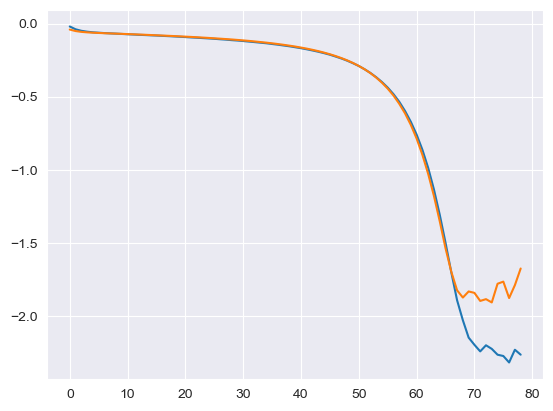

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [14]:
t_x_pred = model.predict(x)[:, 0]

625/625 [==============================] - 1s 1ms/step


In [15]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

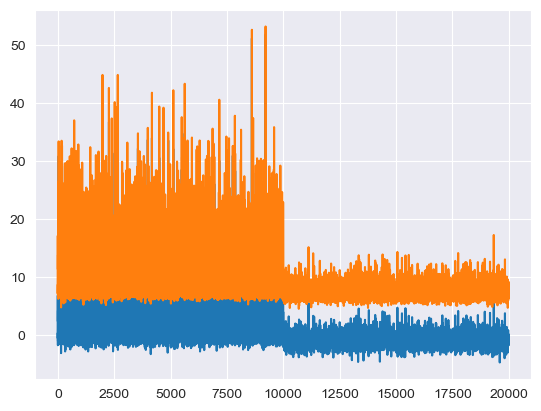

In [16]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

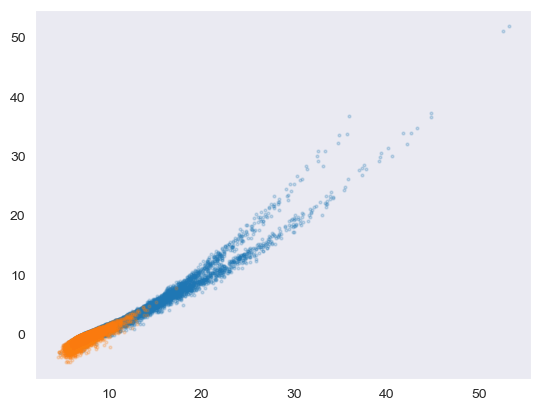

In [17]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

In [18]:
DV_fun(y, t_x_pred)

1.8059549

In [19]:
DV_fun(y, t_x_opt)

2.0462300003059717

In [20]:
# new data

x1_new = np.random.multivariate_normal(mu1.flatten(), Sigma1, size=n)
x2_new = np.random.multivariate_normal(mu2.flatten(), Sigma2, size=n)

x_new = np.vstack([x1_new, x2_new])

t_x_pred = model.predict(x_new)[:, 0]
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

625/625 [==============================] - 1s 945us/step


In [21]:
DV_fun(y, t_x_pred)

2.3602638

In [22]:
DV_fun(y, t_x_opt)

2.368197227647678

### f)

In [23]:
def NWJ_loss(y_true, y_pred):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(y_pred, y_true))/n1
    second_term = tf.math.reduce_sum(tf.math.multiply(tf.math.exp(tf.subtract(y_pred, tf.convert_to_tensor(1.0))), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2
    return -(first_term - second_term)

In [24]:
def NWJ_fun(y, t):
    return np.mean(t[y==1])-np.mean(np.exp(t[y==0]-1))

In [25]:
np.random.seed(123)

mu1 = np.asarray([0.2, 0.2, 0.2, 0, 0]).T
mu2 = np.asarray([0, 0, 0.2, 0.2, 0.2]).T
n = 10000
ro1 = 0.1
ro2 = -0.2

Sigma1 = np.full((5, 5), ro1)
Sigma2 = np.full((5, 5), ro2)
np.fill_diagonal(Sigma1, 1)
np.fill_diagonal(Sigma2, 1)

x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)

x = np.vstack([x1, x2])
y = np.asarray([1.0]*n + [0.0]*n)

mu1 = np.reshape(mu1, (-1,1))
mu2 = np.reshape(mu2, (-1,1))


In [26]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=5e-3)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=NWJ_loss)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [28]:
hist = model.fit(x_train, y_train, epochs=200, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/200
15/15 [==============================] - 1s 12ms/step - loss: 0.0890 - val_loss: 0.0168
Epoch 2/200
15/15 [==============================] - 0s 5ms/step - loss: 0.0114 - val_loss: 2.4929e-04
Epoch 3/200
15/15 [==============================] - 0s 4ms/step - loss: -0.0039 - val_loss: -0.0125
Epoch 4/200
15/15 [==============================] - 0s 5ms/step - loss: -0.0155 - val_loss: -0.0222
Epoch 5/200
15/15 [==============================] - 0s 4ms/step - loss: -0.0245 - val_loss: -0.0299
Epoch 6/200
15/15 [==============================] - 0s 5ms/step - loss: -0.0317 - val_loss: -0.0360
Epoch 7/200
15/15 [==============================] - 0s 4ms/step - loss: -0.0376 - val_loss: -0.0408
Epoch 8/200
15/15 [==============================] - 0s 5ms/step - loss: -0.0424 - val_loss: -0.0446
Epoch 9/200
15/15 [==============================] - 0s 4ms/step - loss: -0.0461 - val_loss: -0.0477
Epoch 10/200
15/15 [==============================] - 0s 4ms/step - loss: -0.0492 - val_lo

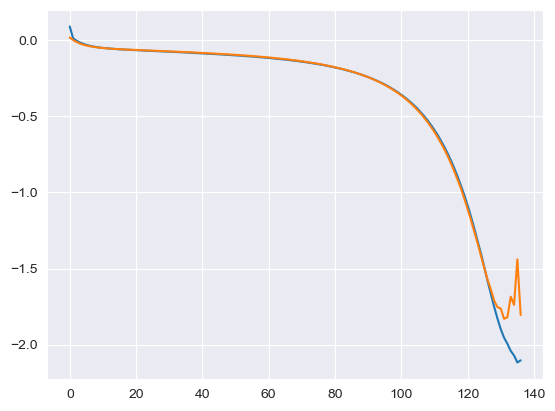

In [29]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [30]:
t_x_pred = model.predict(x)[:, 0]

625/625 [==============================] - 1s 984us/step


In [31]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

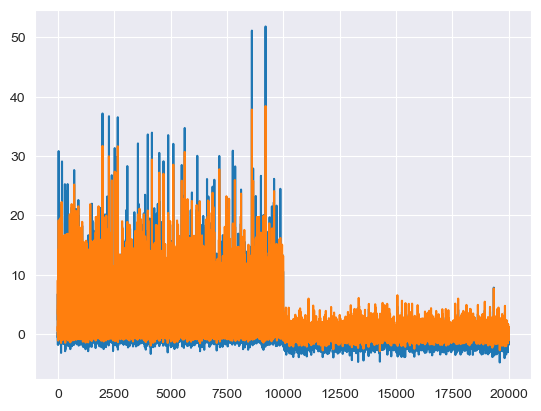

In [32]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

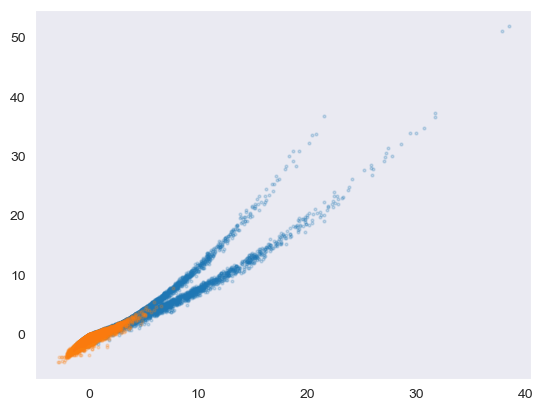

In [33]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

In [34]:
NWJ_fun(y, t_x_pred)

2.0839312

In [35]:
NWJ_fun(y, t_x_opt)

1.7473387277077388

In [36]:
# new data

x1_new = np.random.multivariate_normal(mu1.flatten(), Sigma1, size=n)
x2_new = np.random.multivariate_normal(mu2.flatten(), Sigma2, size=n)

x_new = np.vstack([x1_new, x2_new])

t_x_pred = model.predict(x_new)[:, 0]
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

625/625 [==============================] - 1s 954us/step


In [37]:
NWJ_fun(y, t_x_pred)

2.1833005

In [38]:
NWJ_fun(y, t_x_opt)

1.8822475353066346

Results:

KL = 1.7333333333333343
DV_ratios of densities = 2.0462300003059717
DV_neural network = 1.8478403
DV_ratios of densities_new data = 2.368197227647678
DV_neural network_new data = 2.3640594
NWJ_ratios of densities = 1.7473387277077388
NWJ_neural network = 2.0605216
NWJ_ratios of densities_new data = 1.8822475353066346
NWJ_neural network_new data = 2.1833005

This experiment was performed only for a single seed, so it should be repeated for better statistical significance. However, it appears that both methods of estimation can give relatively close values to the true value. Based on a single run, it seems like DV estimation is better with neural networks than relying on densities, while for NWJ the opposite is true. The conclusions could be influenced by the model design and training strategy.